First steps with scikit-learn – training a perceptron

In [13]:
from sklearn import datasets
import numpy as np 
iris = datasets.load_iris()
X =iris.data[:,[2,3]]
y = iris.target 

In [ ]:
print('class labels : ', np.unique(y))

class labrls :  [0 1 2]


Note that the train_test_split function already shuffles the training datasets internally before splitting;

In [15]:
from sklearn.model_selection import train_test_split 
x_train , x_test , y_train , y_test = train_test_split(X,y,test_size=0.3, random_state =1 , stratify=y)

In [16]:
print('labels counts in y :', np.bincount(y))
print('Labels counts in y_train:', np.bincount(y_train))
print('Labels counts in y_test:', np.bincount(y_test))

labels counts in y : [50 50 50]
Labels counts in y_train: [35 35 35]
Labels counts in y_test: [15 15 15]


In [31]:
from sklearn.preprocessing import StandardScaler 
sc = StandardScaler()
sc.fit(x_train)
X_train_std = sc.transform(x_train)
x_test_std = sc.transform(x_test)

In [32]:
from sklearn.linear_model import Perceptron
ppn = Perceptron(eta0=0.1 , random_state =1)
ppn.fit(X_train_std, y_train)

,penalty,None
,alpha,0.0001
,l1_ratio,0.15
,fit_intercept,True
,max_iter,1000
,tol,0.001
,shuffle,True
,verbose,0
,eta0,0.1
,n_jobs,None
,random_state,1


In [19]:
y_pred = ppn.predict(x_test_std)
print('Misclassified examples: %d' % (y_test != y_pred).sum())

Misclassified examples: 1


In [20]:
from sklearn.metrics import accuracy_score 
print('Accuracy: %.3f' % accuracy_score(y_test, y_pred))

Accuracy: 0.978


In [21]:
print('Accuracy: %.3f' % ppn.score(x_test_std, y_test))
Accuracy: 0.978

Accuracy: 0.978


In [22]:
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt

# To check recent matplotlib compatibility
import matplotlib
from distutils.version import LooseVersion


def plot_decision_regions(X, y, classifier, test_idx=None, resolution=0.02):

    # setup marker generator and color map
    markers = ('o', 's', '^', 'v', '<')
    colors = ('red', 'blue', 'lightgreen', 'gray', 'cyan')
    cmap = ListedColormap(colors[:len(np.unique(y))])

    # plot the decision surface
    x1_min, x1_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    x2_min, x2_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolution),
                           np.arange(x2_min, x2_max, resolution))
    lab = classifier.predict(np.array([xx1.ravel(), xx2.ravel()]).T)
    lab = lab.reshape(xx1.shape)
    plt.contourf(xx1, xx2, lab, alpha=0.3, cmap=cmap)
    plt.xlim(xx1.min(), xx1.max())
    plt.ylim(xx2.min(), xx2.max())

    # plot class examples
    for idx, cl in enumerate(np.unique(y)):
        plt.scatter(x=X[y == cl, 0], 
                    y=X[y == cl, 1],
                    alpha=0.8, 
                    c=colors[idx],
                    marker=markers[idx], 
                    label=f'Class {cl}', 
                    edgecolor='black')

    # highlight test examples
    if test_idx:
        # plot all examples
        X_test, y_test = X[test_idx, :], y[test_idx]

        plt.scatter(X_test[:, 0],
                    X_test[:, 1],
                    c='none',
                    edgecolor='black',
                    alpha=1.0,
                    linewidth=1,
                    marker='o',
                    s=100, 
                    label='Test set')      

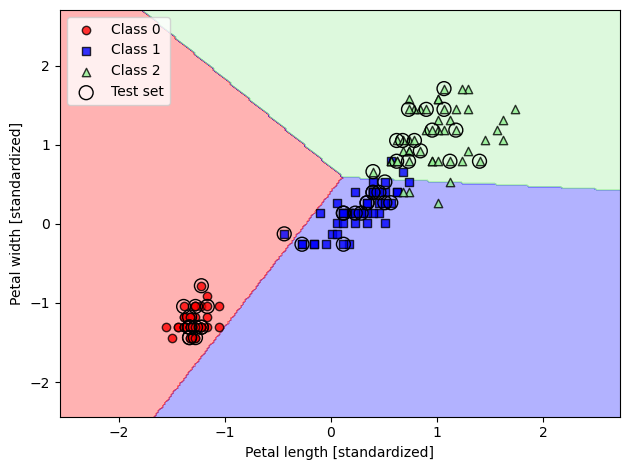

In [ ]:
X_combined_std = np.vstack((X_train_std, x_test_std))
y_combined = np.hstack((y_train, y_test))

plot_decision_regions(X=X_combined_std, y=y_combined,
                      classifier=ppn, test_idx=range(105, 150))
plt.xlabel('Petal length [standardized]')
plt.ylabel('Petal width [standardized]')
plt.legend(loc='upper left')

plt.tight_layout()
#plt.savefig('figures/03_01.png', dpi=300)
plt.show()

## Modeling class probabilities via logistic regression

logit function, which is simply the logarithm of the odds (log-odds):

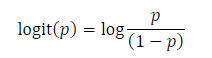

The
logit function takes input values in the range 0 to 1 and transforms them into values over the entire
real-number range.

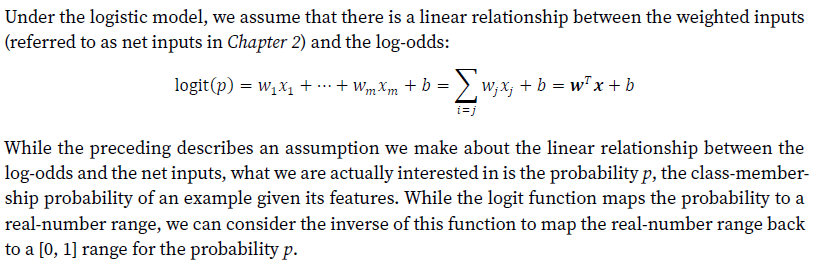

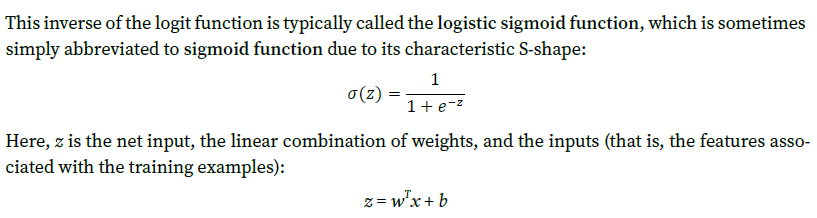


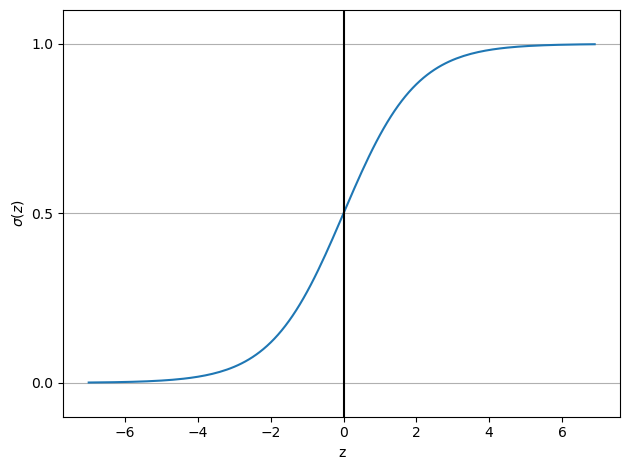

In [24]:
import matplotlib.pyplot as plt 
import numpy as np 

def sigmoid(z):
    return 1/(1.0+ np.exp(-z))
z= np.arange(-7,7,0.1)
sigma_z = sigmoid(z)
plt.plot(z, sigma_z)
plt.axvline(0.0, color='k')
plt.ylim(-0.1, 1.1)
plt.xlabel('z')
plt.ylabel('$\sigma (z)$')
plt.yticks([0.0, 0.5, 1.0])
ax = plt.gca()
ax.yaxis.grid(True)
plt.tight_layout()
plt.show()

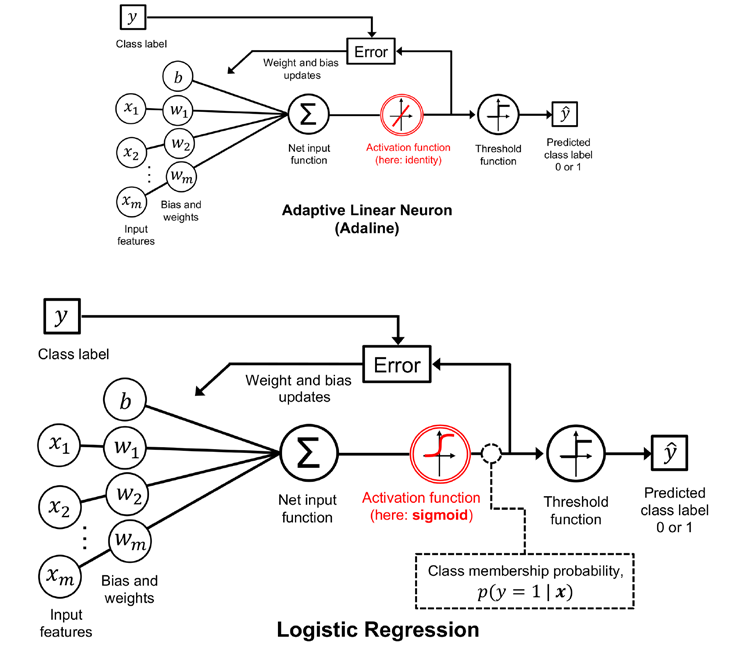

Learning the model weights via the logistic loss function

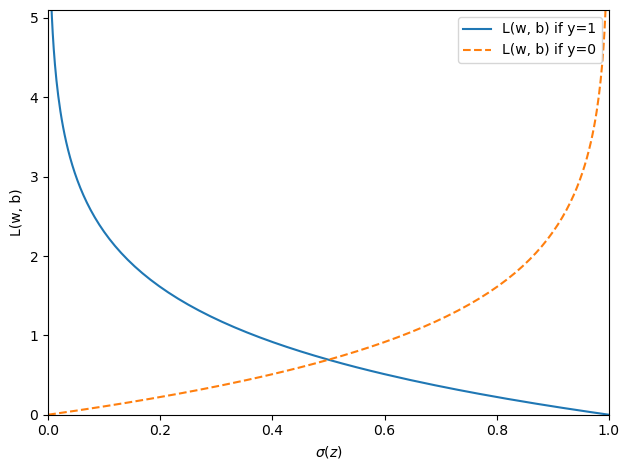

In [26]:
def loss_1(z):
    return - np.log(sigmoid(z))


def loss_0(z):
    return - np.log(1 - sigmoid(z))

z = np.arange(-10, 10, 0.1)
sigma_z = sigmoid(z)

c1 = [loss_1(x) for x in z]
plt.plot(sigma_z, c1, label='L(w, b) if y=1')

c0 = [loss_0(x) for x in z]
plt.plot(sigma_z, c0, linestyle='--', label='L(w, b) if y=0')

plt.ylim(0.0, 5.1)
plt.xlim([0, 1])
plt.xlabel('$\sigma(z)$')
plt.ylabel('L(w, b)')
plt.legend(loc='best')
plt.tight_layout()
#plt.savefig('figures/03_04.png', dpi=300)
plt.show()

In [25]:
class LogisticRegressionGD:
    """Gradient descent-based logistic regression classifier.

    Parameters
    ------------
    eta : float
      Learning rate (between 0.0 and 1.0)
    n_iter : int
      Passes over the training dataset.
    random_state : int
      Random number generator seed for random weight
      initialization.


    Attributes
    -----------
    w_ : 1d-array
      Weights after training.
    b_ : Scalar
      Bias unit after fitting.
    losses_ : list
       Log loss function values in each epoch.

    """
    def __init__(self, eta=0.01, n_iter=50, random_state=1):
        self.eta = eta
        self.n_iter = n_iter
        self.random_state = random_state

    def fit(self, X, y):
        """ Fit training data.

        Parameters
        ----------
        X : {array-like}, shape = [n_examples, n_features]
          Training vectors, where n_examples is the number of examples and
          n_features is the number of features.
        y : array-like, shape = [n_examples]
          Target values.

        Returns
        -------
        self : Instance of LogisticRegressionGD

        """
        rgen = np.random.RandomState(self.random_state)
        self.w_ = rgen.normal(loc=0.0, scale=0.01, size=X.shape[1])
        self.b_ = 0.0
        self.losses_ = []

        for i in range(self.n_iter):
            net_input = self.net_input(X)
            output = self.activation(net_input)
            errors = (y - output)
            self.w_ += self.eta * X.T.dot(errors) / X.shape[0]
            self.b_ += self.eta * errors.mean()
            loss = (-y.dot(np.log(output)) - (1 - y).dot(np.log(1 - output))) / X.shape[0]
            self.losses_.append(loss)
        return self

    def net_input(self, X):
        """Calculate net input"""
        return np.dot(X, self.w_) + self.b_

    def activation(self, z):
        """Compute logistic sigmoid activation"""
        return 1. / (1. + np.exp(-np.clip(z, -250, 250)))

    def predict(self, X):
        """Return class label after unit step"""
        return np.where(self.activation(self.net_input(X)) >= 0.5, 1, 0)

When we fit a logistic regression model, we have to keep in mind that it only works for binary classification
tasks.

let’s consider only setosa and versicolor flowers (classes 0 and 1) and check that our implementation
of logistic regression works:

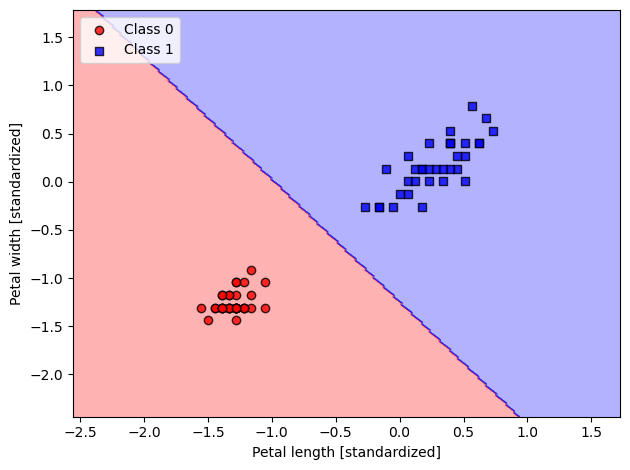

In [26]:
x_train_01_subset = x_train_std[(y_train == 0) | (y_train == 1)]
y_train_01_subset = y_train[(y_train == 0) | (y_train == 1)]

lrgd = LogisticRegressionGD(eta=0.3, n_iter=1000, random_state=1)
lrgd.fit(x_train_01_subset,
         y_train_01_subset)

plot_decision_regions(X=x_train_01_subset, 
                      y=y_train_01_subset,
                      classifier=lrgd)

plt.xlabel('Petal length [standardized]')
plt.ylabel('Petal width [standardized]')
plt.legend(loc='upper left')

plt.tight_layout()
#plt.savefig('figures/03_05.png', dpi=300)
plt.show()

Note that there exist many different algorithms for solving optimization problems. For
minimizing convex loss functions, such as the logistic regression loss, it is recommended
to use more advanced approaches than regular stochastic gradient descent (SGD). In
fact, scikit-learn implements a whole range of such optimization algorithms, which can
be specified via the solver parameter, namely, 'newton-cg', 'lbfgs', 'liblinear',
'sag', and 'saga'.

Training a logistic regression model with scikit-learn

C = 100.0: The inverse of regularization strength. A large value (100) means weaker regularization → model fits more closely to training data.



c:\Users\Dell\anaconda3\envs\mlbook\lib\site-packages\sklearn\linear_model\_logistic.py:1281: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


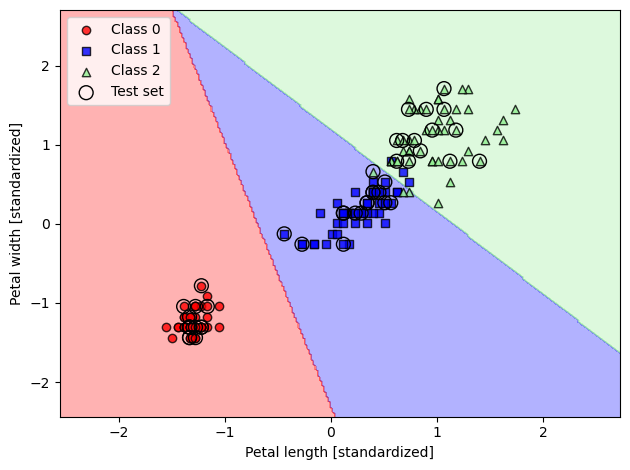

In [ ]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression(C = 100.0 , solver ='lbfgs',multi_class='ovr' )
lr.fit(X_train_std, y_train)
plot_decision_regions(X_combined_std, y_combined,
                      classifier=lr, test_idx=range(105, 150))
plt.xlabel('Petal length [standardized]')
plt.ylabel('Petal width [standardized]')
plt.legend(loc='upper left')
plt.tight_layout()
#plt.savefig('figures/03_06.png', dpi=300)
plt.show()

In [28]:
lr.predict_proba(x_test_std[:3,:])

array([[6.63770505e-09, 1.44747233e-01, 8.55252760e-01],
       [8.34031210e-01, 1.65968790e-01, 3.20815954e-13],
       [8.48822884e-01, 1.51177116e-01, 2.57998350e-14]])

In [29]:
lr.predict_proba(x_test_std[:3, :]).argmax(axis=1)

array([2, 0, 0])

In [30]:
lr.predict(x_test_std[:3, :])

array([2, 0, 0])

if you want to predict the class label of a single flower example: scikit-learn
expects a two-dimensional array as data input; thus, we have to convert a single row slice into such a
format first. One way to convert a single row entry into a two-dimensional data array is to use NumPy’s
reshape method to add a new dimension

In [42]:
lr.predict(x_test_std[0, :].reshape(1, -1))

array([2])

## Tackling overfitting via regularization:
Overfitting is a common problem in machine learning, where a model performs well on training data
but does not generalize well to unseen data (test data).
If a model suffers from overfitting, we also
say that the model has a high variance, which can be caused by having too many parameters


underfitting (high bias): which means that our model is not complex enough to capture the pattern
in the training data well and therefore also suffers from low performance on unseen data.

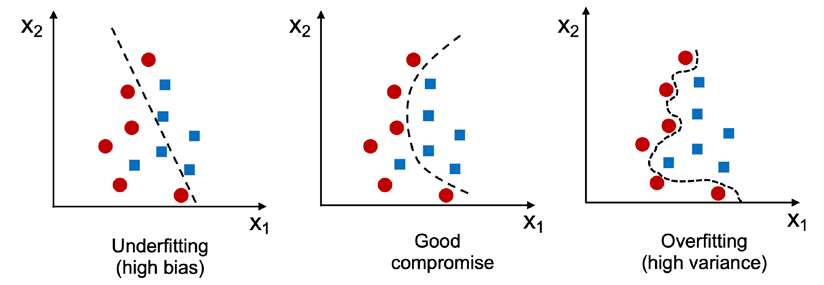

In the context of machine learning models, variance measures the consistency (or variability)
of the model prediction for classifying a particular example if we retrain the model
multiple times, for example, on different subsets of the training dataset. We can say that
the model is sensitive to the randomness in the training data. In contrast, bias measures
how far off the predictions are from the correct values in general if we rebuild the model
multiple times on different training datasets; bias is the measure of the systematic error
that is not due to randomness.

One way of finding a good bias-variance tradeoff is to tune the complexity of the model via regularization.
Regularization is a very useful method for handling collinearity (high correlation among features),
filtering out noise from data, and eventually preventing overfitti

regularization is to introduce additional information to penalize extreme parameter
(weight) values. The most common form of regularization is so-called L2 regularization (sometimes
also called L2 shrinkage or weight decay), which can be written as follows

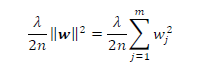


The parameter, C, that is implemented for the LogisticRegression class in scikit-learn comes from
a convention in support vector machines. The term C is
inversely proportional to the regularization parameter, 𝜆. Consequently, decreasing the value of the
inverse regularization parameter, C, means that we are increasing the regularization strength, which
we can visualize by plotting the L2 regularization path for the two weight coefficients:

c:\Users\Dell\anaconda3\envs\mlbook\lib\site-packages\sklearn\linear_model\_logistic.py:1281: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(
c:\Users\Dell\anaconda3\envs\mlbook\lib\site-packages\sklearn\linear_model\_logistic.py:1281: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(
c:\Users\Dell\anaconda3\envs\mlbook\lib\site-packages\sklearn\linear_model\_logistic.py:1281: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(
c:\Users\Dell\anaconda3\envs\mlbook\lib\site-packages\sklearn\linear_model\_

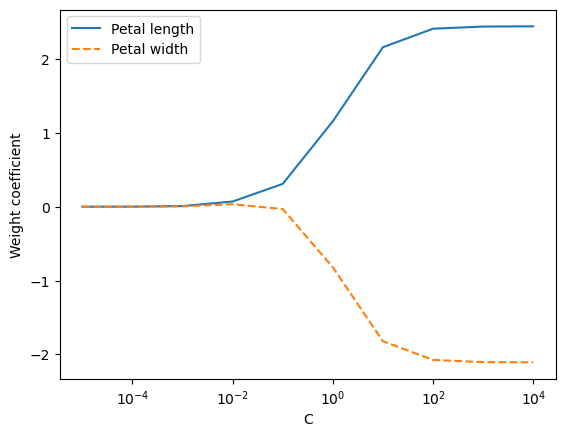

In [33]:
weights, params = [], []
for c in np.arange(-5, 5):
    lr = LogisticRegression(C=10.**c,
                            multi_class='ovr')
    lr.fit(X_train_std, y_train)
    weights.append(lr.coef_[1])
    params.append(10.**c)

weights = np.array(weights)
plt.plot(params, weights[:, 0],
         label='Petal length')
plt.plot(params, weights[:, 1], linestyle='--',
         label='Petal width')
plt.ylabel('Weight coefficient')
plt.xlabel('C')
plt.legend(loc='upper left')
plt.xscale('log')
#plt.savefig('figures/03_08.png', dpi=300)
plt.show()

Increasing the regularization strength can reduce overfitting, so we might ask why we don’t strongly
regularize all models by default. The reason is that we have to be careful when adjusting the regularization
strength. For instance, if the regularization strength is too high and the weights coefficients
approach zero, the model can perform very poorly due to underfitting,

## Maximum margin classification with support vector machines : 
our optimization objective is to maximize the margin.
The margin is defined as the distance between the separating hyperplane (decision boundary) and
the training examples that are closest to this hyperplane, which are the so-called support vectors.

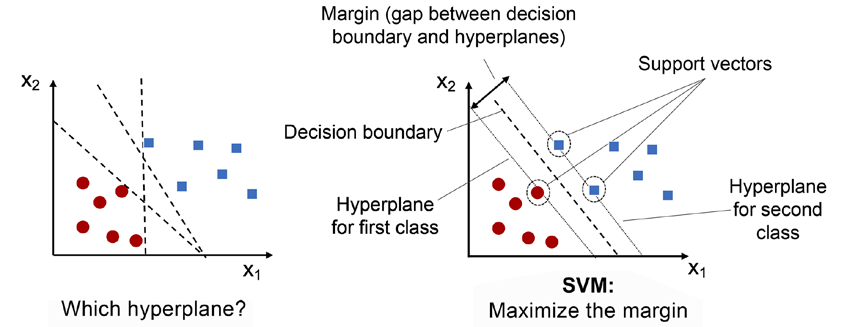

The rationale behind having decision boundaries with large margins is that they tend to have a lower
generalization error, whereas models with small margins are more prone to overfitting.

## Dealing with a nonlinearly separable case using slack variables:
led to  soft-margin classification

Slack variables are extra terms that allow softening the strict separation requirement in SVMs. They measure margin violations and enable SVMs to work on non-separable data.

commonly referred to as C in
SVM contexts.

Large values of C correspond to large error penalties, whereas we are less strict about misclassification
errors if we choose smaller values for C. We can then use the C parameter to control the width of the
margin and therefore tune the bias-variance tradeoff

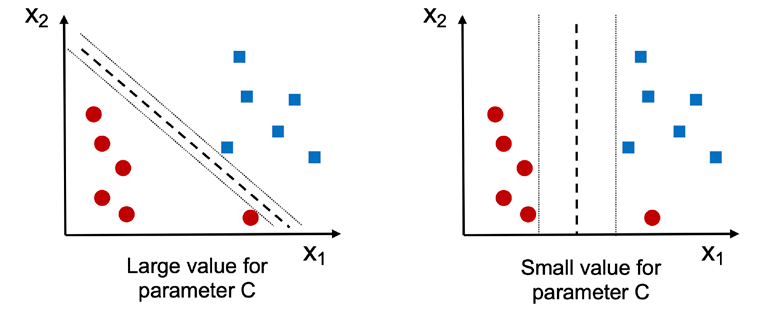

This concept is related to regularization, which we discussed in the previous section in the context of
regularized regression, where decreasing the value of C increases the bias (underfitting) and lowers
the variance (overfitting) of the model.

Kernel: A function that maps data to a higher-dimensional space enabling SVM to handle non-linearly separable data.

When data is not linearly separable i.e it can't be divided by a straight line, SVM uses a technique called kernels to map the data into a higher-dimensional space where it becomes separable.

Linear Kernel: For linear separability.

Polynomial Kernel: Maps data into a polynomial space.

Radial Basis Function (RBF) Kernel: Transforms data into a space based on distances between data points.


C: A regularization term balancing margin maximization and misclassification penalties. A higher C value forces stricter penalty for misclassifications.

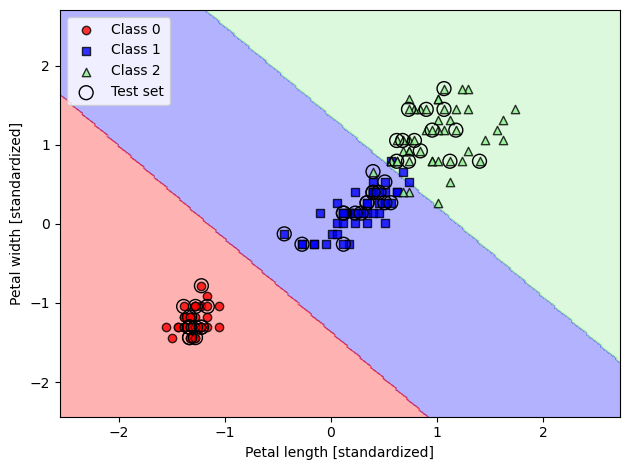

In [36]:
from sklearn.svm import SVC 
svm = SVC(kernel='linear', C=1.0, random_state=1)
svm.fit(X_train_std, y_train)
plot_decision_regions(X_combined_std, 
                      y_combined,
                      classifier=svm, 
                      test_idx=range(105, 150))
plt.xlabel('Petal length [standardized]')
plt.ylabel('Petal width [standardized]')
plt.legend(loc='upper left')
plt.tight_layout()
#plt.savefig('figures/03_11.png', dpi=300)
plt.show()

Logistic regression tries to maximize the conditional likelihoods of the
training data, which makes it more prone to outliers than SVMs.

logistic regression
models can be easily updated, which is attractive when working with streaming data.

Alternative implementations in scikit-learn

In [39]:
from sklearn.linear_model import SGDClassifier
ppn = SGDClassifier(loss = 'Perceptron')
lr = SGDClassifier(loss = 'log')
svm = SGDClassifier(loss = 'hinge')

Kernel methods for linearly inseparable data

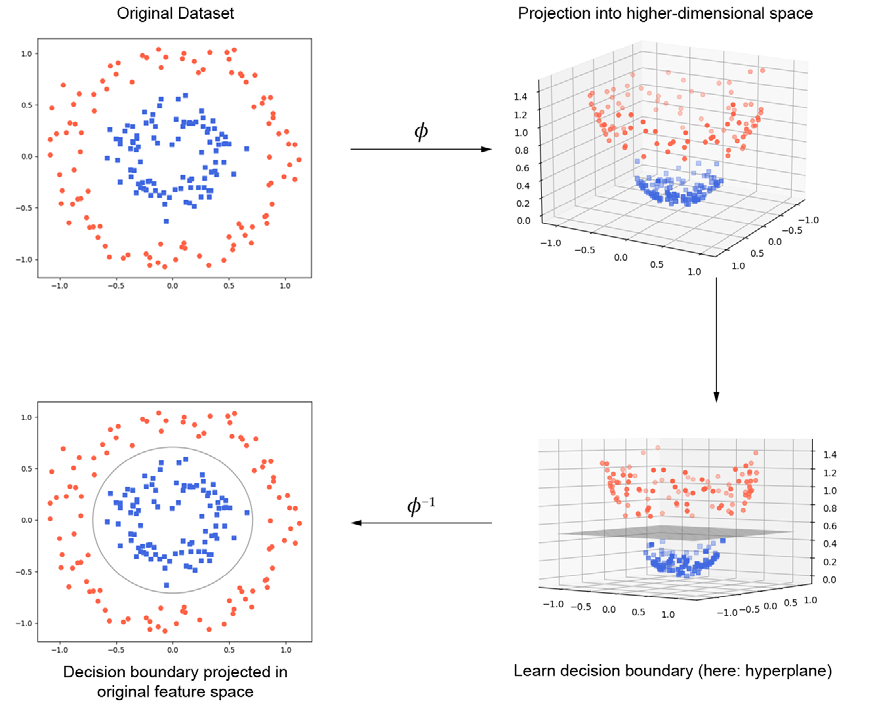

one problem with this mapping approach is that the construction of the new features is
computationally very expensive, especially if we are dealing with high-dimensional data. This is where
the so-called kernel trick comes into play.

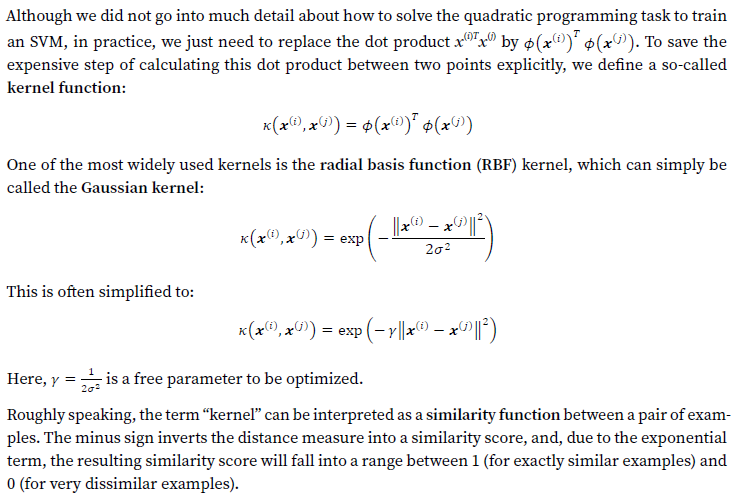

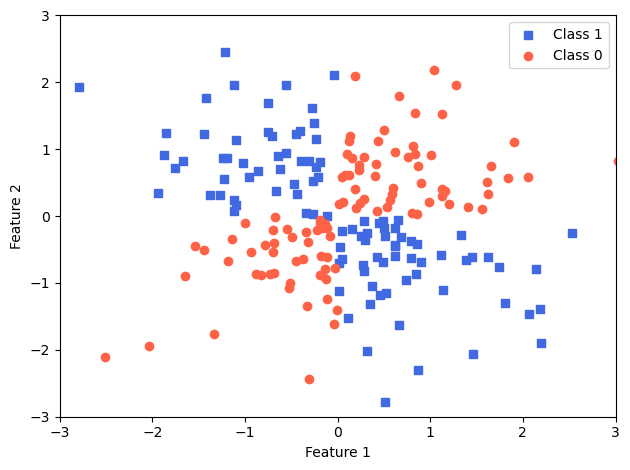

In [40]:
import matplotlib.pyplot as plt
import numpy as np

np.random.seed(1)
X_xor = np.random.randn(200, 2)
y_xor = np.logical_xor(X_xor[:, 0] > 0,
                       X_xor[:, 1] > 0)
y_xor = np.where(y_xor, 1, 0)

plt.scatter(X_xor[y_xor == 1, 0],
            X_xor[y_xor == 1, 1],
            c='royalblue',
            marker='s',
            label='Class 1')
plt.scatter(X_xor[y_xor == 0, 0],
            X_xor[y_xor == 0, 1],
            c='tomato',
            marker='o',
            label='Class 0')

plt.xlim([-3, 3])
plt.ylim([-3, 3])
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')

plt.legend(loc='best')
plt.tight_layout()
#plt.savefig('figures/03_12.png', dpi=300)
plt.show()

The 𝛾 parameter, which we set to gamma=0.1, can be understood as a cut-off parameter for the Gaussian
sphere. If we increase the value for 𝛾𝛾 , we increase the influence or reach of the training examples,
which leads to a tighter and bumpier decision boundary.

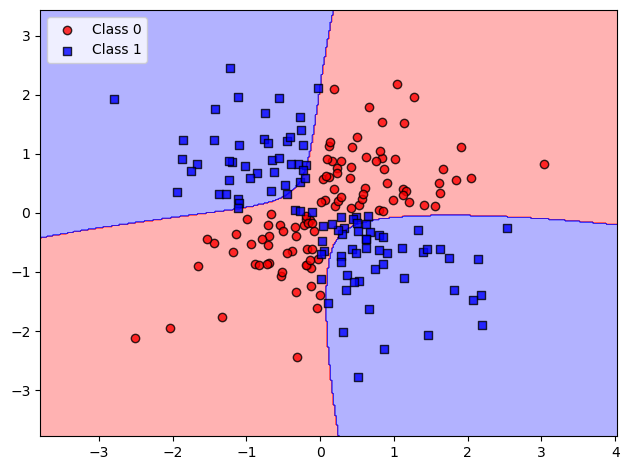

In [45]:
svm = SVC(kernel='rbf', random_state=1, gamma=0.1, C=10.0)
svm.fit(X_xor, y_xor)
plot_decision_regions(X_xor, y_xor,
                      classifier=svm)

plt.legend(loc='upper left')
plt.tight_layout()
#plt.savefig('figures/03_14.png', dpi=300)
plt.show()

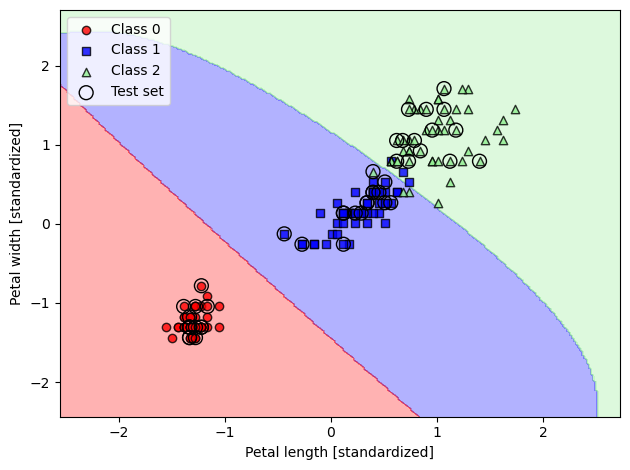

In [46]:
from sklearn.svm import SVC

svm = SVC(kernel='rbf', random_state=1, gamma=0.2, C=1.0)
svm.fit(X_train_std, y_train)

plot_decision_regions(X_combined_std, y_combined,
                      classifier=svm, test_idx=range(105, 150))
plt.xlabel('Petal length [standardized]')
plt.ylabel('Petal width [standardized]')
plt.legend(loc='upper left')
plt.tight_layout()
#plt.savefig('figures/03_15.png', dpi=300)
plt.show()

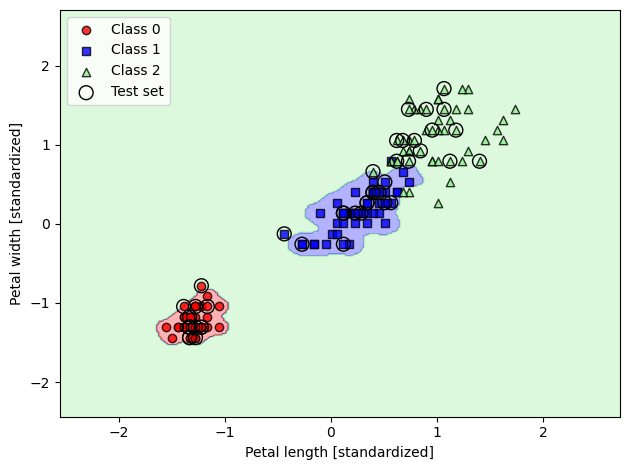

In [48]:
svm = SVC(kernel='rbf', random_state=1, gamma=100.0, C=1.0)
svm.fit(X_train_std, y_train)

plot_decision_regions(X_combined_std, y_combined, 
                      classifier=svm, test_idx=range(105, 150))
plt.xlabel('Petal length [standardized]')
plt.ylabel('Petal width [standardized]')
plt.legend(loc='upper left')
plt.tight_layout()
#plt.savefig('figures/03_16.png', dpi=300)
plt.show()

## Decision tree learning:

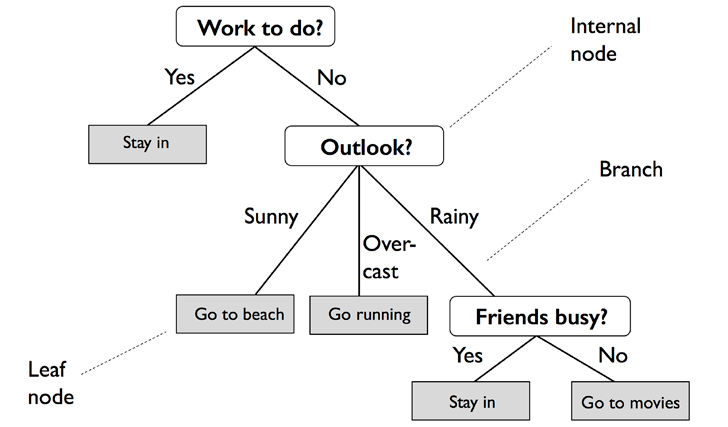
we start at the tree root and split the data on the feature that results in
the largest information gain (IG)In
an iterative process, we can then repeat this splitting procedure at each child node until the leaves are
pure. This means that the training examples at each node all belong to the same class. In practice, this
can result in a very deep tree with many nodes, which can easily lead to overfitting. Thus, we typically
want to prune the tree by setting a limit for the maximum depth of the tree.

## Maximizing IG : 

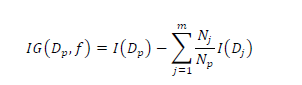

Here, f is the feature to perform the split; Dp and Dj are the dataset of the parent and jth child node; I
is our impurity measure; Np is the total number of training examples at the parent node; and Nj is the
number of examples in the jth child node


the information gain is simply the difference
between the impurity of the parent node and the sum of the child node impurities—

for simplicity and to reduce
the combinatorial search space, most libraries (including scikit-learn) implement binary decision
trees. This means that each parent node is split into two child nodes, Dleft and Dright:

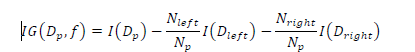

The three impurity measures or splitting criteria that are commonly used in binary decision trees
are Gini impurity (IG), entropy (IH), and the classification error (IE).

definition of
entropy for all non-empty classes (𝑝𝑝(𝑖𝑖|𝑡𝑡) ≠ 0 ):

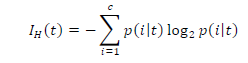

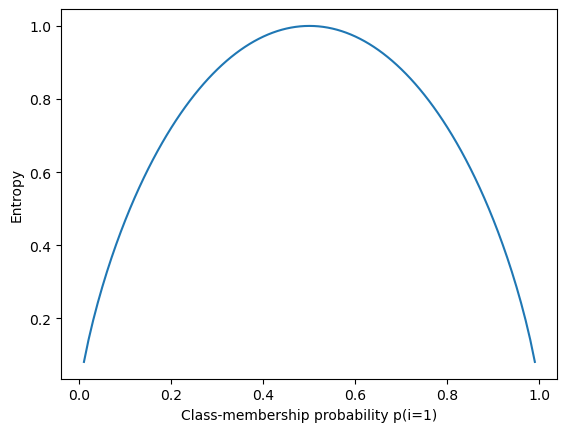

In [49]:
def entropy(p):
    return - p * np.log2(p) - (1 - p) * np.log2((1 - p))

x = np.arange(0.0, 1.0, 0.01)
ent = [entropy(p) if p != 0 else None 
       for p in x]

plt.ylabel('Entropy')
plt.xlabel('Class-membership probability p(i=1)')
plt.plot(x, ent)
#plt.savefig('figures/03_26.png', dpi=300)
plt.show()

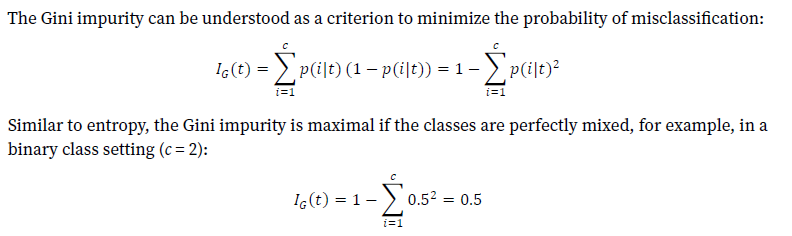

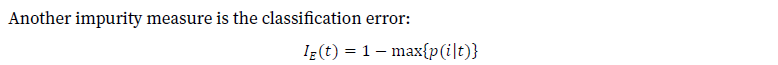

This is a useful criterion for pruning, but not recommended for growing a decision tree, since it is
less sensitive to changes in the class probabilities of the nodes.

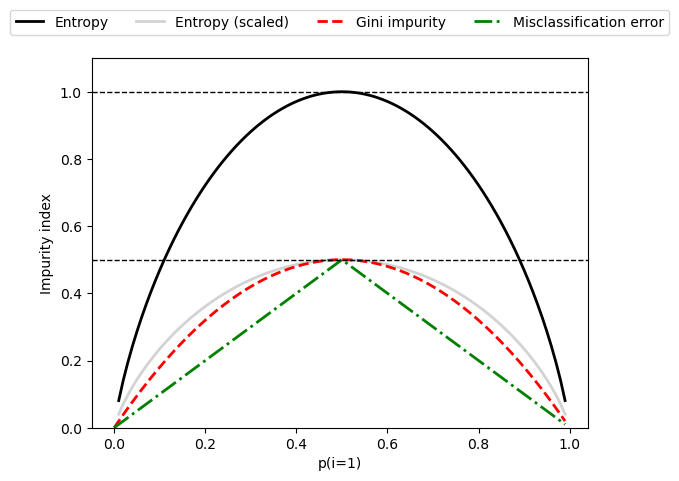

In [50]:
import matplotlib.pyplot as plt
import numpy as np


def gini(p):
    return p * (1 - p) + (1 - p) * (1 - (1 - p))


def entropy(p):
    return - p * np.log2(p) - (1 - p) * np.log2((1 - p))


def error(p):
    return 1 - np.max([p, 1 - p])

x = np.arange(0.0, 1.0, 0.01)

ent = [entropy(p) if p != 0 else None for p in x]
sc_ent = [e * 0.5 if e else None for e in ent]
err = [error(i) for i in x]

fig = plt.figure()
ax = plt.subplot(111)
for i, lab, ls, c, in zip([ent, sc_ent, gini(x), err], 
                          ['Entropy', 'Entropy (scaled)', 
                           'Gini impurity', 'Misclassification error'],
                          ['-', '-', '--', '-.'],
                          ['black', 'lightgray', 'red', 'green', 'cyan']):
    line = ax.plot(x, i, label=lab, linestyle=ls, lw=2, color=c)

ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.15),
          ncol=5, fancybox=True, shadow=False)

ax.axhline(y=0.5, linewidth=1, color='k', linestyle='--')
ax.axhline(y=1.0, linewidth=1, color='k', linestyle='--')
plt.ylim([0, 1.1])
plt.xlabel('p(i=1)')
plt.ylabel('Impurity index')
#plt.savefig('figures/03_19.png', dpi=300, bbox_inches='tight')
plt.show()

Building a decision tree:


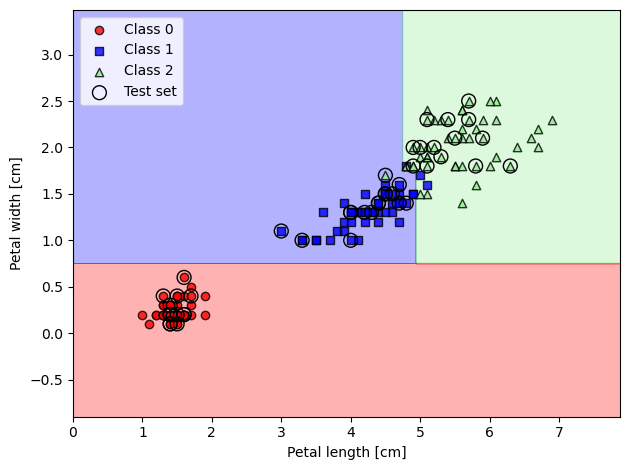

In [52]:
from sklearn.tree import DecisionTreeClassifier

tree_model = DecisionTreeClassifier(criterion='gini', 
                                    max_depth=4, 
                                    random_state=1)
tree_model.fit(x_train, y_train)

X_combined = np.vstack((x_train, x_test))
y_combined = np.hstack((y_train, y_test))
plot_decision_regions(X_combined, y_combined, 
                      classifier=tree_model,
                      test_idx=range(105, 150))

plt.xlabel('Petal length [cm]')
plt.ylabel('Petal width [cm]')
plt.legend(loc='upper left')
plt.tight_layout()
#plt.savefig('figures/03_20.png', dpi=300)
plt.show()

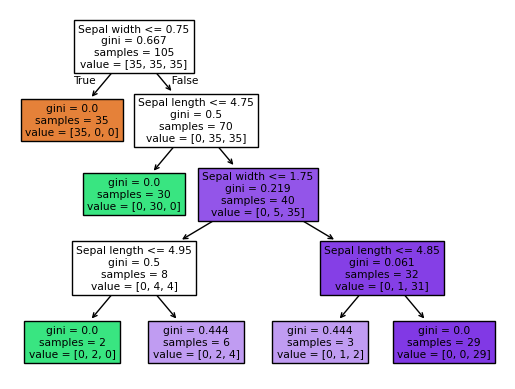

In [53]:
from sklearn import tree

feature_names = ['Sepal length', 'Sepal width',
                 'Petal length', 'Petal width']
tree.plot_tree(tree_model,
               feature_names=feature_names,
               filled=True)

#plt.savefig('figures/03_21_1.pdf')
plt.show()

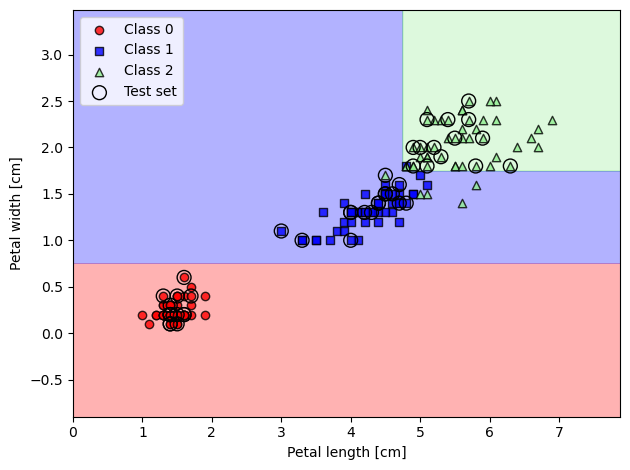

In [54]:
from sklearn.tree import DecisionTreeClassifier

tree_model = DecisionTreeClassifier(criterion='gini', 
                                    max_depth=3, 
                                    random_state=1)
tree_model.fit(x_train, y_train)

X_combined = np.vstack((x_train, x_test))
y_combined = np.hstack((y_train, y_test))
plot_decision_regions(X_combined, y_combined, 
                      classifier=tree_model,
                      test_idx=range(105, 150))

plt.xlabel('Petal length [cm]')
plt.ylabel('Petal width [cm]')
plt.legend(loc='upper left')
plt.tight_layout()
#plt.savefig('figures/03_20.png', dpi=300)
plt.show()

## Combining multiple decision trees via random forests: 

A random forest can be considered
as an ensemble of decision trees

The idea behind a random forest is to average multiple (deep) decision
trees that individually suffer from high variance to build a more robust model that has a better
generalization performance and is less susceptible to overfitting.

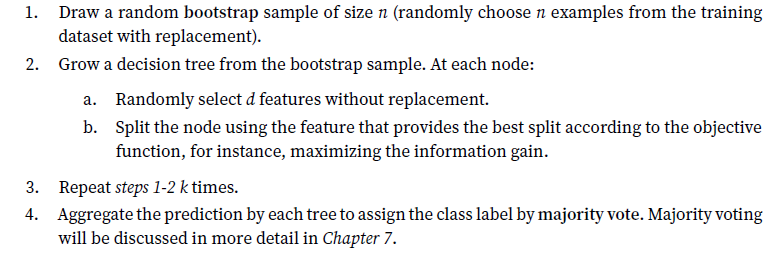

We should note one slight modification in step 2 when we are training the individual decision trees:
instead of evaluating all features to determine the best split at each node, we only consider a random
subset of those.

Although random forests don’t offer the same level of interpretability as decision trees, a big advantage
of random forests is that we don’t have to worry so much about choosing good hyperparameter values.
We typically don’t need to prune the random forest since the ensemble model is quite robust to noise
from averaging the predictions among the individual decision trees.

The only parameter that we
need to care about in practice is the number of trees, k, (step 3) that we choose for the random forest.
Typically, the larger the number of trees, the better the performance of the random forest classifier
at the expense of an increased computational cost.

Decreasing the size of the bootstrap sample increases the diversity among the individual trees since
the probability that a particular training example is included in the bootstrap sample is lower.

shrinking the size of the bootstrap samples may increase the randomness of the random forest,and it can
help to reduce the effect of overfitting.

the
size of the bootstrap sample is chosen to be equal to the number of training examples in the original
training dataset,

we want to choose a value that is smaller than the total number of features in the training
dataset. A reasonable default that is used in scikit-learn and other implementations is 𝑑 = √𝑚 , where
m is the number of features in the training dataset.

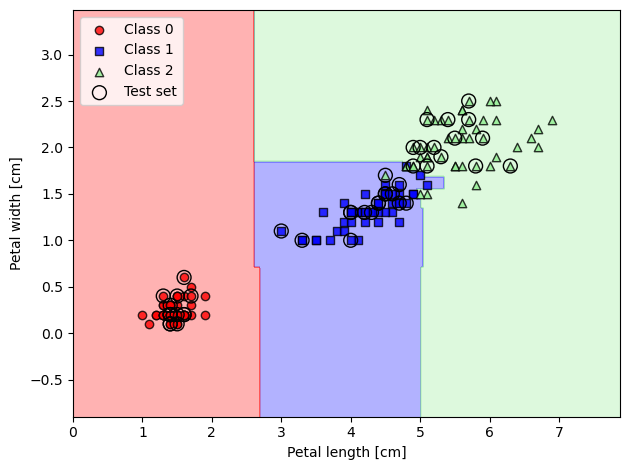

In [ ]:
from sklearn.ensemble import RandomForestClassifier

forest = RandomForestClassifier(n_estimators=25, #25 decision trees
                                random_state=1,
                                n_jobs=2) #parallelize the model training using multiple cores of our computer
forest.fit(x_train, y_train)

plot_decision_regions(X_combined, y_combined, 
                      classifier=forest, test_idx=range(105, 150))

plt.xlabel('Petal length [cm]')
plt.ylabel('Petal width [cm]')
plt.legend(loc='upper left')
plt.tight_layout()
#plt.savefig('figures/03_2.png', dpi=300)
plt.show()

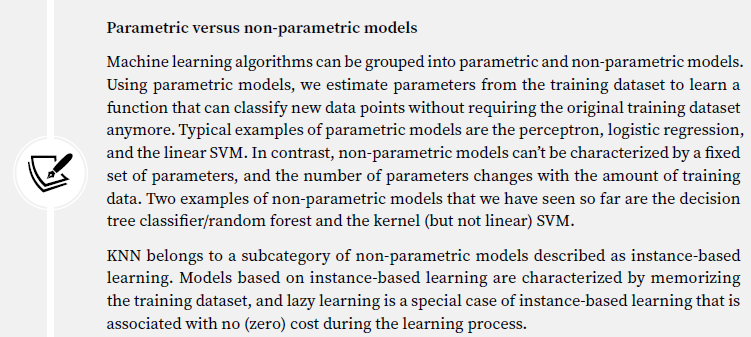

## K-nearest neighbors:
KNN is a typical example of a lazy learner. It is called “lazy” not because of its apparent simplicity, but
because it doesn’t learn a discriminative function from the training data but memorizes the training
dataset instead.

steps:

1. Choose the number of k and a distance metric

2. Find the k-nearest neighbors of the data

3. Assign the class label by majority vote

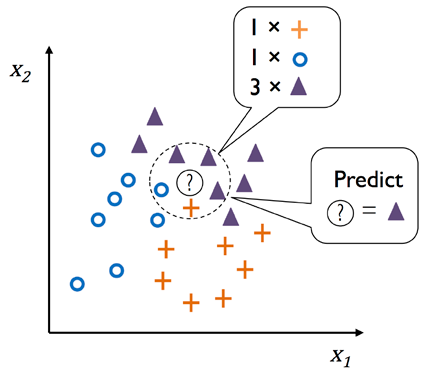

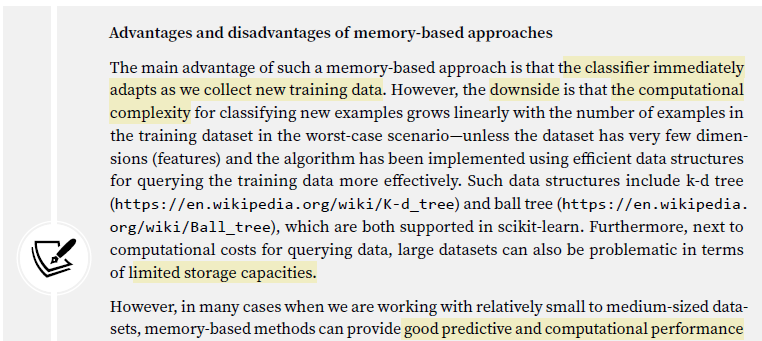


The minkowski distance that we used in the previous code is just a generalization of
the Euclidean and Manhattan distance,

It becomes the Euclidean distance if we set the parameter p=2 or the Manhattan distance at p=1.

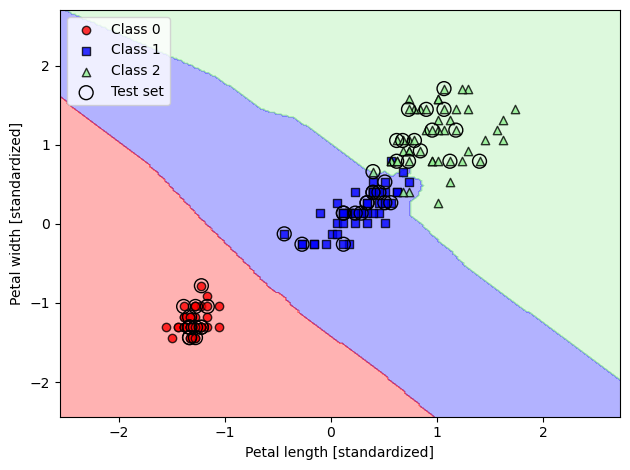

In [57]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=5, 
                           p=2, 
                           metric='minkowski')
knn.fit(X_train_std, y_train)

plot_decision_regions(X_combined_std, y_combined, 
                      classifier=knn, test_idx=range(105, 150))

plt.xlabel('Petal length [standardized]')
plt.ylabel('Petal width [standardized]')
plt.legend(loc='upper left')
plt.tight_layout()
#plt.savefig('figures/03_24_figures.png', dpi=300)
plt.show()

In the case of a tie, the scikit-learn implementation of the KNN algorithm will prefer
the neighbors with a closer distance to the data record to be classified. If the neighbors
have similar distances, the algorithm will choose the class label that comes first in the
training dataset.

it is important to mention that KNN is very susceptible to overfitting due to the curse of dimensionality.

in models where regularization is not applicable, such as decision trees and KNN we can use feature selection and dimensionality reduction techniques to help us to avoid the curse of
dimensionality.